## 🏃 Half-Marathon Time Predictor

### Train Pipeline Model

In [1]:
import os
from dotenv import load_dotenv
import boto3
import io
from botocore.exceptions import ClientError
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from pycaret.regression import setup, pull, compare_models
from pycaret.regression import *

In [2]:
load_dotenv()

s3 = boto3.client(
    "s3",
)
BUCKET_NAME = 'bohemspace'

### Preparing data for model training

In [3]:
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [4]:
def read_csv_from_do(bucket_name, file_name, s3):
    """
    Checks if a file exists in DigitalOcean Spaces and reads it into a DataFrame.
    """
    try:
        # Attempt to retrieve the object
        response = s3.get_object(Bucket=bucket_name, Key=file_name)
        
        # Convert the StreamingBody to a pandas-compatible format
        df = pd.read_csv(io.BytesIO(response['Body'].read()), sep=';')
        print(f"Success: '{file_name}' loaded.")
        return df

    except ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == "NoSuchKey":
            print(f"Error: The file '{file_name}' does not exist in bucket '{bucket_name}'.")
        elif error_code == "AccessDenied":
            print("Error: Check your DigitalOcean Permissions/API Keys.")
        else:
            print(f"Unexpected S3 Error: {e}")
        return None
    except Exception as e:
        print(f"General Error: {e}")
        return None

In [5]:
def age_category_to_int(category: str) -> int:
    """
    Converts a 3-character age category string into integer.
    Ignores the first character and converts last two characters to int.
    
    Example:
        "A05" -> 5
        "B12" -> 12
    """
    
    if not isinstance(category, str):
        raise TypeError("Input must be a string.")
        
    if len(category) != 3:
        raise ValueError("Input must be exactly 3 characters long.")
    
    numeric_part = category[1:]  # take last two characters
    
    if not numeric_part.isdigit():
        raise ValueError("Last two characters must be digits.")
    
    return int(numeric_part)


In [6]:
def exclude_important_columns(year):
    file = 'halfmarathon_wroclaw_20' + year + '__final.csv'

    # df_raw = pd.read_csv(file, sep=';')
    df_raw = read_csv_from_do(BUCKET_NAME, file, s3)
    print (f'Year : 20{year}') 
    
    # select only important columns
    important_columns =  ['Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']
    df = df_raw[important_columns].copy()
    print(f'Raw df       : {len(df)}')
    
    # rename columns
    df.columns = ['gender', 'age_category', '5km_time', 'time']

    # delete all NaN rows
    df = df.dropna().copy()
    print(f'~NaN df      : {len(df)}')    
    
    # delete all rows where time is equal ['DNF', 'DNS'] 
    exclude_values = ['DNF', 'DNS']
    df = df[~df['time'].isin(exclude_values)].copy()
    print(f'~DNF, ~DNS df: {len(df)}')

    # numeric values for column gender
    mapping = {'M': 0, 'K': 1}
    if not df['gender'].isin(mapping.keys()).all():
        raise ValueError("Unexpected values in 'gender' column")
    df['gender'] = df['gender'].map(mapping)

    # convert time to seconds
    df['5km_time'] = df['5km_time'].apply(convert_time_to_seconds)
    df['time'] = df['time'].apply(convert_time_to_seconds)

    # convert age_category to int
    df['age_category'] = df['age_category'].apply(age_category_to_int)
    return df

### Data from the Wrocław Half Marathon 2023

**Reading data from Digital Ocean, selecting columns, converting character columns to numeric columns, and eliminating records with missing data**

In [7]:
df23 = exclude_important_columns('23')
df23

Success: 'halfmarathon_wroclaw_2023__final.csv' loaded.
Year : 2023
Raw df       : 8950
~NaN df      : 8114
~DNF, ~DNS df: 8114


,gender,age_category,5km_time,time
0,0,30,877,3899
1,0,30,888,3983
2,0,20,946,4104
3,0,30,971,4216
4,0,20,972,4227
...,...,...,...,...
8145,1,40,2512,12108
8146,1,70,2718,12116
8147,0,70,2447,12142
8148,1,30,2309,12211


### Data from the Wrocław Half Marathon 2024

**Reading data from Digital Ocean, selecting columns, converting character columns to numeric columns, and eliminating records with missing data**

In [8]:
df24 = exclude_important_columns('24')

Success: 'halfmarathon_wroclaw_2024__final.csv' loaded.
Year : 2024
Raw df       : 13007
~NaN df      : 10279
~DNF, ~DNS df: 10279


### Combination of data from the Wrocław 2023 and Wrocław 2024 half marathons into marathon.csv

In [9]:
df = pd.concat([df23, df24], axis=0, ignore_index=True)
len(df)

18393

In [10]:
df.to_csv("marathon.csv", sep=";", index=False)

## Histograms of age groups occurring in marathon.csv, broken down by gender.

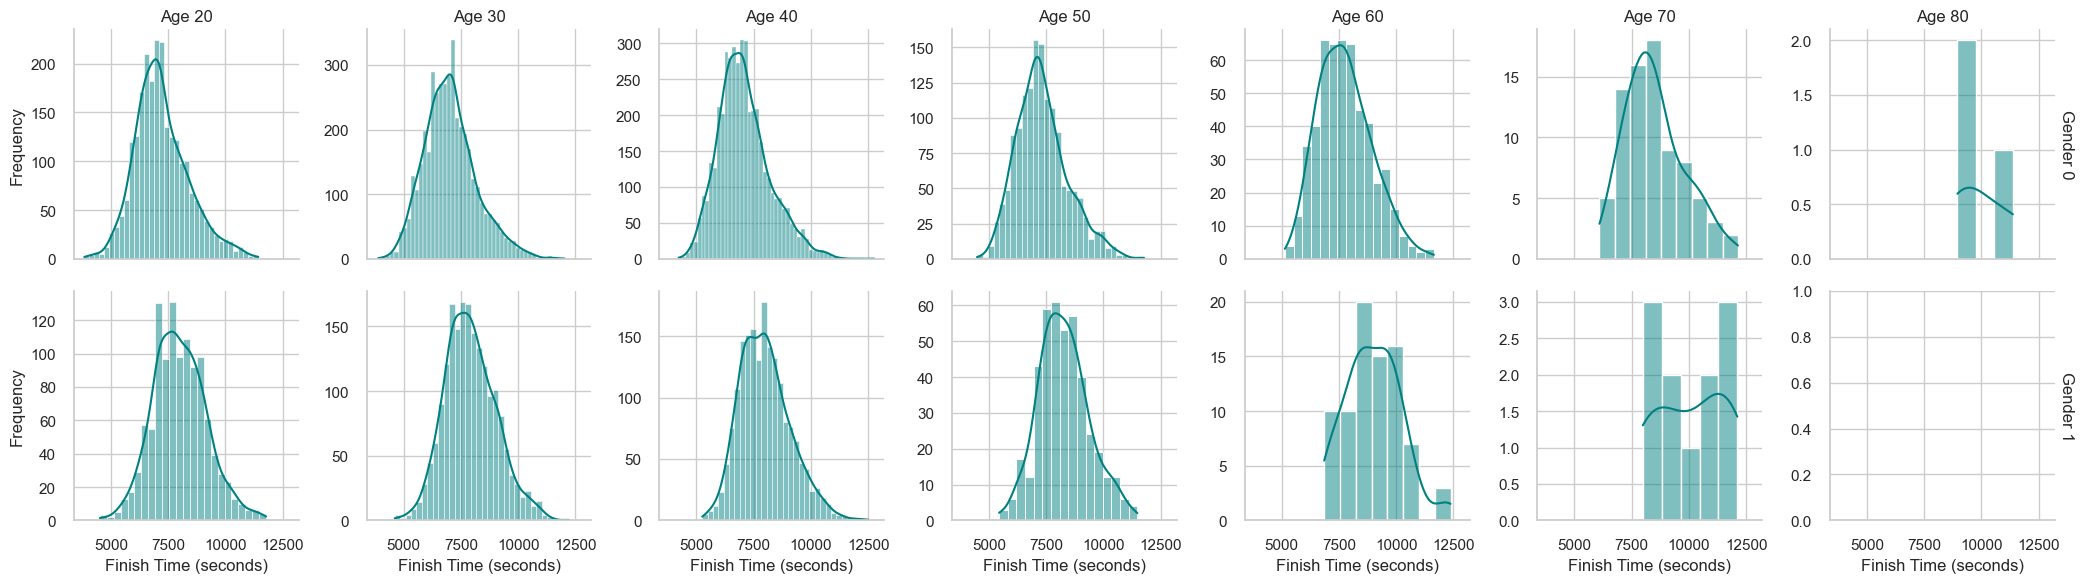

In [11]:
# Mapping for better readability (assuming 0=Male, 1=Female or vice-versa, but I'll stick to 0 and 1 as in data)
# Actually, I'll just use the numerical labels or add descriptive ones if I want.
# Let's keep it simple as requested.

# Setting up the FacetGrid
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df, row="gender", col="age_category", margin_titles=True, sharex=True, sharey=False)
g.map(sns.histplot, "time", kde=True, color='teal')

# Set titles and labels
g.set_axis_labels("Finish Time (seconds)", "Frequency")
g.set_titles(row_template="Gender {row_name}", col_template="Age {col_name}")

# Adjust layout
plt.tight_layout()
plt.savefig('marathon_histograms.png')

## Remove outliers

In [12]:
def process_outliers(df):
    """
    Groups the data by gender and age_category and removes 
    outliers based on the IQR method for the 'time' column.
    """
    
    # 2. Define the cleaning function for each group
    def clean_group(group):
        Q1 = group['time'].quantile(0.25)
        Q3 = group['time'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtering data within the bounds
        return group[(group['time'] >= lower_bound) & (group['time'] <= upper_bound)]

    # 3. Apply the function per demographic group
    # group_keys=False keeps the original index structure
    df_cleaned = df.groupby(['gender', 'age_category'], group_keys=False).apply(clean_group)
    
    # Calculate statistics
    removed = len(df) - len(df_cleaned)
    print(f"Original Records: {len(df)}")
    print(f"Cleaned Records: {len(df_cleaned)}")
    print(f"Outliers Removed: {removed} ({removed/len(df):.2%})")
    
    return df_cleaned

### Execute and Save

In [13]:
df_cleaned = process_outliers(df)
df_cleaned.to_csv('marathon_ready_for_ml.csv', index=False, sep=';')

Original Records: 18393
Cleaned Records: 18064
Outliers Removed: 329 (1.79%)


### Visualizing the impact

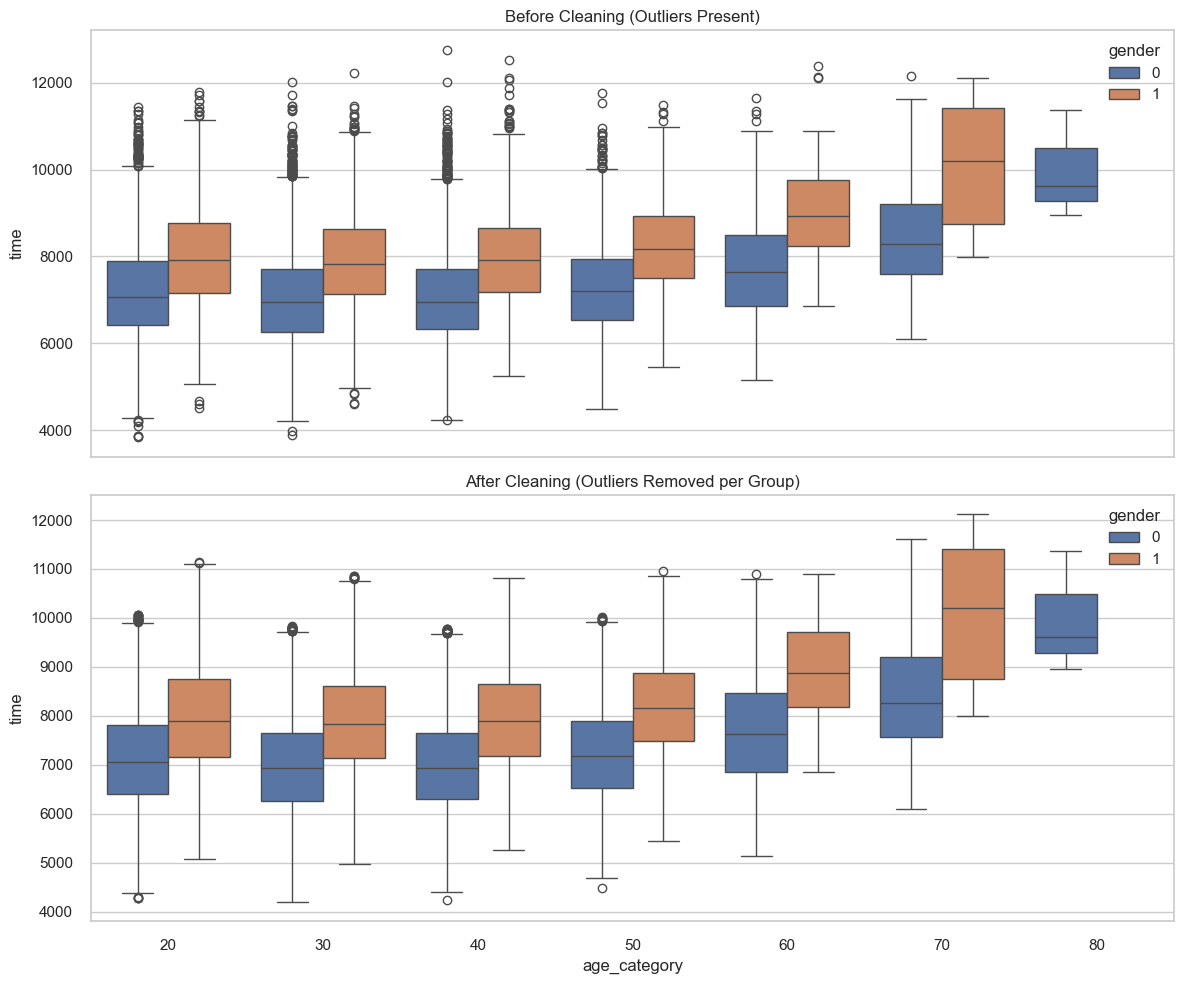

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
sns.boxplot(data=df, x='age_category', y='time', hue='gender', ax=ax1)
ax1.set_title("Before Cleaning (Outliers Present)")
sns.boxplot(data=df_cleaned, x='age_category', y='time', hue='gender', ax=ax2)
ax2.set_title("After Cleaning (Outliers Removed per Group)")
plt.tight_layout()
plt.savefig('outlier_comparison.png')

## Regression model

In [15]:
df_cleaned

,gender,age_category,5km_time,time
6,0,20,937,4278
8,0,20,1030,4456
10,0,20,1029,4483
12,0,20,1035,4496
27,0,20,1100,4626
...,...,...,...,...
16194,1,70,1899,8373
17408,1,70,2083,9114
17685,1,70,2098,9403
18355,1,70,2445,11213


### Initialize Setup
 - categorical_features: explicitly telling PyCaret that gender/age are categories
 - session_id: for reproducibility (seed)
 - log_experiment: optional, but good for tracking

In [16]:
s = setup(
    data=df_cleaned, 
    target='time', 
    categorical_features=['gender', 'age_category'],
    session_id=123,
    normalize=True,      # Good practice for many regression models
    transformation=True, # Adjusts for skewness in finishing times
    verbose=True
)

,Description,Value
0,Session id,123
1,Target,time
2,Target type,Regression
3,Original data shape,"(18064, 4)"
4,Transformed data shape,"(18064, 10)"
5,Transformed train set shape,"(12644, 10)"
6,Transformed test set shape,"(5420, 10)"
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


### Compare Models

In [17]:
print("Comparing models to find the best performer...")
best_model = compare_models()

Comparing models to find the best performer...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,289.6429,154118.8911,392.3930,0.8812,0.0507,0.0383,0.0630
lightgbm,Light Gradient Boosting Machine,291.8268,156661.4643,395.6574,0.8792,0.0511,0.0386,0.1120
knn,K Neighbors Regressor,317.6881,184508.6938,429.3720,0.8577,0.0556,0.0421,0.0420
lasso,Lasso Regression,296.0183,187346.4439,426.5589,0.8557,0.0517,0.0392,0.3120
ridge,Ridge Regression,295.9883,187353.7515,426.5599,0.8557,0.0517,0.0392,0.0180
lar,Least Angle Regression,295.9851,187358.2747,426.5634,0.8557,0.0517,0.0392,0.0180
llar,Lasso Least Angle Regression,296.0187,187346.8255,426.5594,0.8557,0.0517,0.0392,0.0190
br,Bayesian Ridge,295.9892,187353.1978,426.5596,0.8557,0.0517,0.0392,0.0190
omp,Orthogonal Matching Pursuit,296.5998,188374.1693,427.6082,0.8549,0.0517,0.0393,0.0170
huber,Huber Regressor,291.5496,188938.9238,428.5025,0.8545,0.0519,0.0384,0.0210


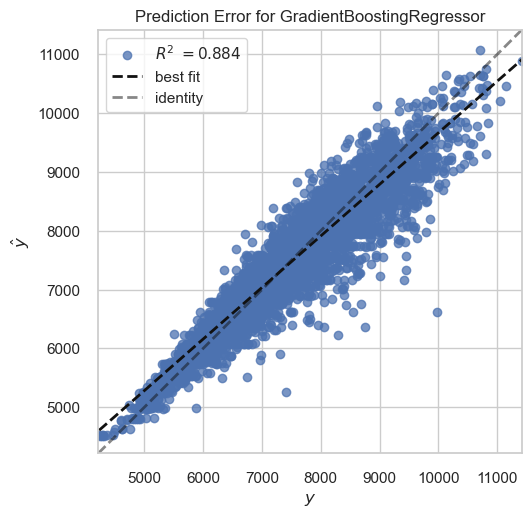

In [18]:
plot_model(best_model, plot='error')

### View results

In [19]:
results_df = pull()
print("\nTop Performing Models:")
print(results_df.head())


Top Performing Models:
                                    Model       MAE          MSE      RMSE  \
gbr           Gradient Boosting Regressor  289.6429  154118.8911  392.3930   
lightgbm  Light Gradient Boosting Machine  291.8268  156661.4643  395.6574   
knn                 K Neighbors Regressor  317.6881  184508.6938  429.3720   
lasso                    Lasso Regression  296.0183  187346.4439  426.5589   
ridge                    Ridge Regression  295.9883  187353.7515  426.5599   

              R2   RMSLE    MAPE  TT (Sec)  
gbr       0.8812  0.0507  0.0383     0.063  
lightgbm  0.8792  0.0511  0.0386     0.112  
knn       0.8577  0.0556  0.0421     0.042  
lasso     0.8557  0.0517  0.0392     0.312  
ridge     0.8557  0.0517  0.0392     0.018  


### Finalize Model

In [20]:
final_marathon_model = finalize_model(best_model)

### Save the Model - local

In [21]:
save_model(final_marathon_model, 'best_marathon_pipeline')
print("\nModel saved successfully as 'best_marathon_pipeline.pkl'")

Transformation Pipeline and Model Successfully Saved

Model saved successfully as 'best_marathon_pipeline.pkl'


### Save the Model - Digital Ocean Space

In [22]:
def upload_if_not_exists(bucket_name, file_name, s3):
    try:
        # Check if file exists using head_object (efficient, no data transfer)
        s3.head_object(Bucket=bucket_name, Key=file_name)
        print(f"File '{file_name}' already exists in '{bucket_name}'. Skipping.")
        
    except ClientError as e:
        # If a 404 error occurs, the file does not exist
        if e.response['Error']['Code'] == "404":
            print(f"File '{file_name}' not found. Uploading...")
            try:
                s3.upload_file(file_name, bucket_name, file_name)
                print(f"Successfully uploaded '{file_name}'.")
            except FileNotFoundError:
                print(f"Local error: The file '{file_name}' was not found on your disk.")
        else:
            # Handle other potential errors (Permissions, 403, etc.)
            print(f"Error checking bucket: {e}")

In [23]:
upload_if_not_exists(BUCKET_NAME, 'best_marathon_pipeline.pkl', s3)

File 'best_marathon_pipeline.pkl' not found. Uploading...
Successfully uploaded 'best_marathon_pipeline.pkl'.


### Test Model

In [24]:
input_df = pd.DataFrame([{
                        'gender': 1,
                        'age_category': 30,
                        '5km_time': 1200,
                    }])

In [25]:
predictions = predict_model(final_marathon_model, data=input_df)
pred_seconds = predictions['prediction_label'][0]
formatted_time = str(pd.to_timedelta(pred_seconds, unit='s')).split('.')[0]
without_days = formatted_time[7:]
without_days

'01:28:07'